In [26]:
import os, sys
from tqdm import trange

import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy

import torch
from torch import nn
from torch.utils.data import TensorDataset

source = "/home/loek/projects/rnn/source"
sys.path.append(source)

from data import fun_data, grid_data
from preprocessing import Direct, Encoding, OneHot
from compilation import Compiler, Tracker, ScalarTracker, ActivationTracker
from activations import get_activations
from data_analysis.automata import to_automaton_history
from data_analysis.visualization.animation import SliderAnimation
from data_analysis.visualization.activations import (
    ActivationsAnimation,
    FunctionAnimation,
)
from data_analysis.visualization.automata import AutomatonAnimation
from data_analysis.visualization.epochs import EpochAnimation
from data_analysis.visualization.publication import pub_show
from utils.containers import partition
from simulate import rep_sim

from model import MLP

import cProfile
import pstats


is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU available")
else:
    device = torch.device("cpu")
    print("GPU not available")

# device = torch.device("cpu")

GPU available


In [27]:
## Load data
inputs = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
outputs_XOR = np.array([[0], [1], [1], [0]])
outputs_OR = np.array([[0], [1], [1], [1]])

outputs = np.array([[0], [1], [0], [1]])
# outputs = outputs_OR

outputs = torch.from_numpy(outputs.astype(np.float32)).to(device)
inputs = torch.from_numpy(inputs.astype(np.float32)).to(device)

encoding = Direct()

dataset = TensorDataset(inputs, outputs)
train_datasets = [dataset]
val_dataset = [dataset]

tracked_datasets = val_dataset + train_datasets

In [28]:
gain = 0.03
# gain = 2
P = 128
L = 2

In [29]:
## Instantiate model
model = MLP(
    encoding=encoding,
    input_size=inputs.shape[1],
    output_size=outputs.shape[1],
    hidden_dim=P,
    n_hid_layers=L,
    device=device,
    init_std=gain,
    non_linearity=torch.nn.functional.relu,
)

In [30]:
## Setup compiler

# Define hyperparameters
lr = 0.002 / P
n_epochs = 15000

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
compiler = Compiler(model, criterion, optimizer)
compiler.trackers = {
    "loss": ScalarTracker(lambda: compiler.validation(tracked_datasets)),
    "hidden": ActivationTracker(
        model, lambda inputs: model(inputs)[1][int(len(model) / 2)]
    ),
    "output": ActivationTracker(model, lambda inputs: model(inputs)[0]),
}

In [31]:
## Training run
compiler.training_run(
    train_datasets, tracked_datasets, n_epochs=n_epochs, batch_size=100
)

Training:  35%|███▌      | 5290/15000 [01:41<03:05, 52.35steps/s, train_loss=0.00000, val_loss=0.00000]


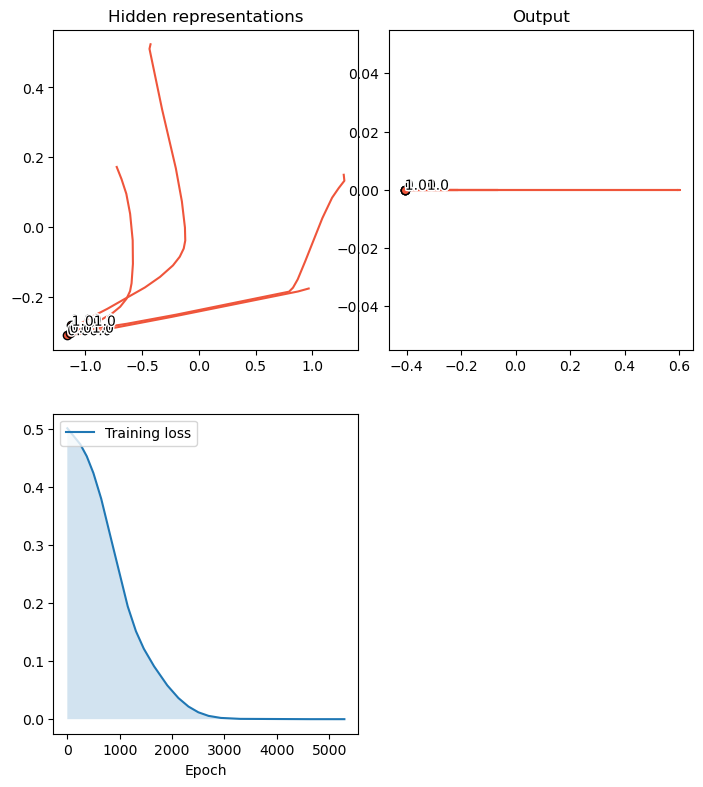

interactive(children=(SelectionSlider(description='Epoch:', options=(0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 10…

In [32]:
## Visualize representation dynamics
data_hid = compiler.trackers["hidden"].get_trace()
data_output = compiler.trackers["output"].get_trace()
query = "Epoch % 10 == 0"
data_hid = data_hid.query(query).copy()
data_output = data_output.query(query).copy()

loss = compiler.trackers["loss"].get_trace()
val_loss = loss.query("Dataset==0")[0].to_numpy()
train_loss = loss.query("Dataset>0").groupby("Epoch").mean()

epochs = list(set(data_output.index.get_level_values("Epoch")))
epochs.sort()

animation = SliderAnimation(
    {
        "Hidden representations": ActivationsAnimation(
            data_hid.query("Dataset != 0"), transform="PCA", plot_labels=True
        ),
        "Output": ActivationsAnimation(
            data_output.query("Dataset != 0"),
            transform="PCA",
            plot_labels=True,
        ),
        "Loss": EpochAnimation(
            graphs={
                "Training loss": train_loss,
                # "Validation loss": val_loss,
            },
            unitless_graphs={},
            # x_bounds=(0, 800),
            # y_bounds=(0, 1),
        ),
    },
    parameters=epochs,
    parameter_name="Epoch",
    fig_size=4,
)

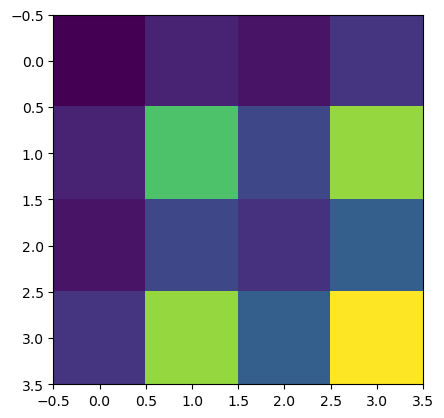

In [33]:
final_epoch = data_hid.index.get_level_values("Epoch")[-1]
h = data_hid.query(f"Epoch=={final_epoch}").query(f"Dataset=={0}")
plt.imshow(h @ h.T)
plt.show()